In [1]:
import numpy as np
import pandas as pd
import konlpy
from konlpy.tag import Mecab
import gensim
from collections import Counter
import os
import tensorflow as tf
from gensim.models.keyedvectors import Word2VecKeyedVectors
import matplotlib.pyplot as plt

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

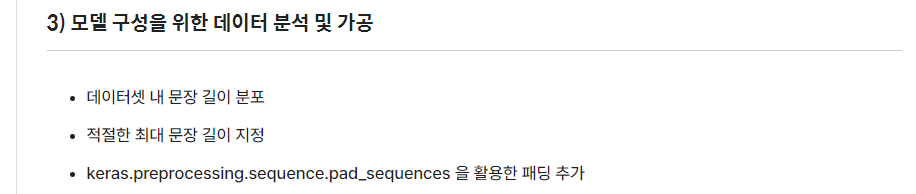

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [6]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [9]:
len(X_train)

146182

In [10]:
len(X_test)

49157

In [11]:
len(word_to_index)

10001

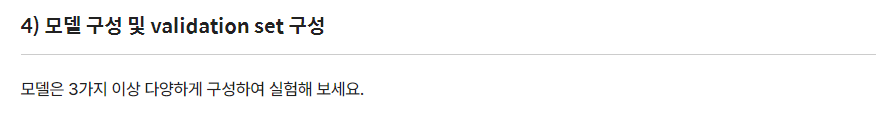

In [12]:
vocab_size = 10001    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [13]:
vocab_size = 10001    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.LSTM(8))
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,897
Trainable params: 160,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
vocab_size = 10001    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_________________________________________________________________


In [15]:
# validation set 10000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


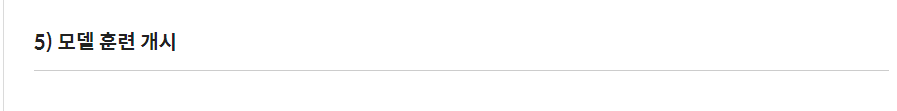

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 7ms/step - loss: 0.5155 - accuracy: 0.7425 - val_loss: 0.3663 - val_accuracy: 0.8401
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3370 - accuracy: 0.8565 - val_loss: 0.3484 - val_accuracy: 0.8482
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3009 - accuracy: 0.8751 - val_loss: 0.3462 - val_accuracy: 0.8494
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2747 - accuracy: 0.8887 - val_loss: 0.3510 - val_accuracy: 0.8494
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2475 - accuracy: 0.9025 - val_loss: 0.3653 - val_accuracy: 0.8471
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2159 - accuracy: 0.9182 - val_loss: 0.3881 - val_accuracy: 0.8428
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.1832 - accuracy: 0.9338 - val_loss: 0.4194 - val_accuracy: 0.8395
Epoch 

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0531 - accuracy: 0.8106
[1.0530775785446167, 0.8105865120887756]


In [18]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5884 - accuracy: 0.6589 - val_loss: 0.3996 - val_accuracy: 0.8348
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3614 - accuracy: 0.8480 - val_loss: 0.3569 - val_accuracy: 0.8445
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3243 - accuracy: 0.8644 - val_loss: 0.3535 - val_accuracy: 0.8464
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3109 - accuracy: 0.8705 - val_loss: 0.3611 - val_accuracy: 0.8448
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3006 - accuracy: 0.8749 - val_loss: 0.3622 - val_accuracy: 0.8446
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2930 - accuracy: 0.8790 - val_loss: 0.3610 - val_accuracy: 0.8450
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2881 - accuracy: 0.8810 - val_loss: 0.3627 - val_accuracy: 0.8439
Epoch 

In [19]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.7145 - val_loss: 0.5293 - val_accuracy: 0.8043
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.4356 - accuracy: 0.8246 - val_loss: 0.3868 - val_accuracy: 0.8317
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3509 - accuracy: 0.8522 - val_loss: 0.3610 - val_accuracy: 0.8408
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3149 - accuracy: 0.8690 - val_loss: 0.3549 - val_accuracy: 0.8446
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2905 - accuracy: 0.8795 - val_loss: 0.3559 - val_accuracy: 0.8462
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2713 - accuracy: 0.8883 - val_loss: 0.3606 - val_accuracy: 0.8454
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2556 - accuracy: 0.8961 - val_loss: 0.3679 - val_accuracy: 0.8450
Epoch 

In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
history_dict_2 = history_2.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
history_dict_3 = history_3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


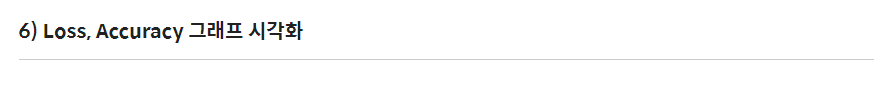

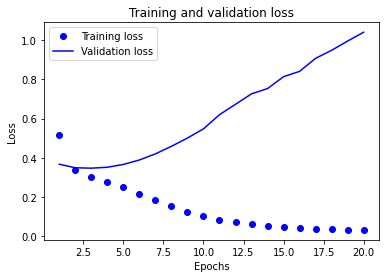

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

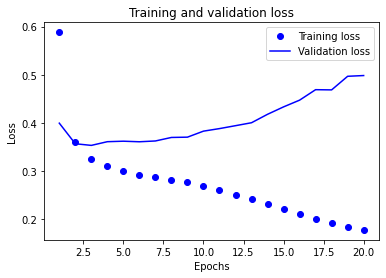

In [24]:
acc_2 = history_dict_2['accuracy']
val_acc_2 = history_dict_2['val_accuracy']
loss_2 = history_dict_2['loss']
val_loss_2 = history_dict_2['val_loss']

epochs = range(1, len(acc_2) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss_2, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

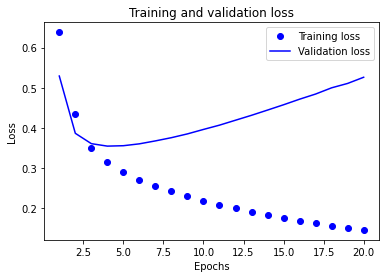

In [25]:
acc_3 = history_dict_3['accuracy']
val_acc_3 = history_dict_3['val_accuracy']
loss_3 = history_dict_3['loss']
val_loss_3 = history_dict_3['val_loss']

epochs = range(1, len(acc_3) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss_3, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

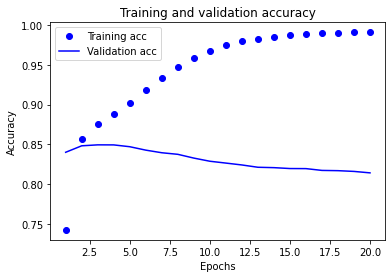

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

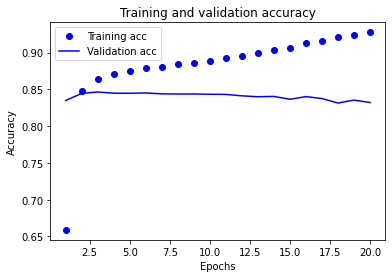

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc_2, 'bo', label='Training acc')
plt.plot(epochs, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

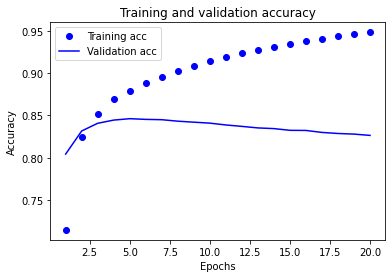

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc_3, 'bo', label='Training acc')
plt.plot(epochs, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

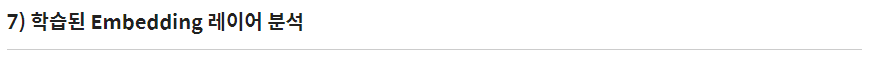

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10001, 16)


In [31]:
# Word2Vec 파일 경로 정의
word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'

# Word2Vec 모델 로드 (.load()와 .wv 사용)
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

# 특정 단어 벡터 확인
vector = word_vectors.wv['끝']  # '끝' 단어의 벡터 가져오기

# 단어 벡터 가져오기
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수

# 임베딩 행렬 초기화
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

In [32]:
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [33]:
from tensorflow.keras.initializers import Constant
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.6761 - accuracy: 0.5584 - val_loss: 0.5947 - val_accuracy: 0.7165
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.5061 - accuracy: 0.7675 - val_loss: 0.4431 - val_accuracy: 0.8025
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.4098 - accuracy: 0.8206 - val_loss: 0.4000 - val_accuracy: 0.8233
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3662 - accuracy: 0.8418 - val_loss: 0.3787 - val_accuracy: 0.8337
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3389 - accuracy: 0.8565 - val_loss: 0.3738 - val_accuracy: 0.8364
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3232 - accuracy: 0.8644 - val_loss: 0.3710 - val_accuracy: 0.8387
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3090 - accuracy: 0.8712 - val_loss: 0.3665 - val_accuracy: 0.8408
Epoch 

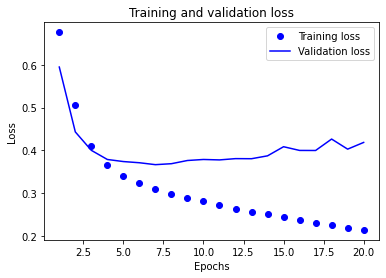

In [35]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

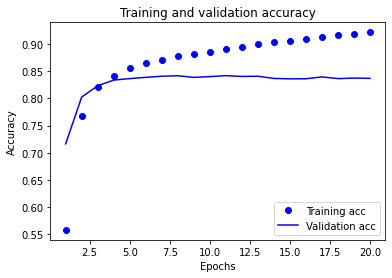

In [36]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4244 - accuracy: 0.8340
[0.42443376779556274, 0.8340216279029846]


# 회고

* ## 정말... 너무 힘들었다... word2vec 한국어 버전을 사용할 때 .wv 만 넣어주면 해결되는 것을 약 2시간동안 고민했다...
* ## 그래도 해결된게 다행이긴하다
* ## 그래서 accuracy를 85% 달성하지 못했다... layer를 좀 만 더 어떻게 하면 가능할 것 같은데 시간나면 해봐야겠다.